# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator

import pandas as pd

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

# Nicer plotting
%config InlineBackend.figure_format = 'retina'

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict, enable_errors=True) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if enable_errors and np.any(inputs["x"] > 0.8):
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, linked_variables={})

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()

f(in1, enable_errors=False)

{'f1': 0.11401572022703582}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
# Create Evaluator
ev = Evaluator(function=f)

In [8]:
# Single input evaluation
ev.evaluate(in1)

{'f1': 0.11401572022703582,
 'xopt_runtime': 0.2053979580000007,
 'xopt_error': False}

In [9]:
# Dataframe evaluation
in10 = pd.DataFrame({
    "x":np.linspace(0,1,10),
    "y":np.linspace(0,1,10)
})
ev.evaluate_data(in10)


f1  xopt_runtime  xopt_error   
0  0.000000      0.305440       False  \
1  0.024691      0.103032       False   
2  0.098765      0.201869       False   
3  0.222222      0.400367       False   
4  0.395062      0.300886       False   
5  0.617284      0.401745       False   
6  0.888889      0.105210       False   
7  1.209877      0.401745       False   
8       NaN      0.105072        True   
9       NaN      0.302975        True   

                                      xopt_error_str  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5                                                NaN  
6                                                NaN  
7                                                NaN  
8  Traceback (most recent call last):\n  File "/U...  
9  Traceback (most recent call last):\n  File "/U...

In [10]:
# Dataframe submission (returns futures dict)
futures = ev.submit_data(in10)
for future in futures:
    print(future.result())

{'f1': 0.0, 'xopt_runtime': 0.20219837500000093, 'xopt_error': False}
{'f1': 0.024691358024691357, 'xopt_runtime': 0.4005366249999991, 'xopt_error': False}
{'f1': 0.09876543209876543, 'xopt_runtime': 0.10519004100000018, 'xopt_error': False}
{'f1': 0.2222222222222222, 'xopt_runtime': 0.3029279169999999, 'xopt_error': False}
{'f1': 0.3950617283950617, 'xopt_runtime': 0.10048208299999928, 'xopt_error': False}
{'f1': 0.617283950617284, 'xopt_runtime': 0.4054515419999998, 'xopt_error': False}
{'f1': 0.8888888888888888, 'xopt_runtime': 0.2052499999999995, 'xopt_error': False}
{'f1': 1.2098765432098761, 'xopt_runtime': 0.3036889580000004, 'xopt_error': False}
{'xopt_runtime': 0.10600862499999941, 'xopt_error': True, 'xopt_error_str': 'Traceback (most recent call last):\n  File "/Users/chrisonian/Code/GitHub/Xopt/xopt/utils.py", line 132, in safe_call\n    result = func(*args, **kwargs)\n  File "/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/ipykernel_6422/4275037860.py", line 6, in f\n    

In [11]:
# Dataframe evaluation, vectorized
ev.vectorized = True
ev.evaluate_data(in10)


xopt_runtime  xopt_error                                     xopt_error_str
0      0.206437        True  Traceback (most recent call last):\n  File "/U...
1      0.206437        True  Traceback (most recent call last):\n  File "/U...
2      0.206437        True  Traceback (most recent call last):\n  File "/U...
3      0.206437        True  Traceback (most recent call last):\n  File "/U...
4      0.206437        True  Traceback (most recent call last):\n  File "/U...
5      0.206437        True  Traceback (most recent call last):\n  File "/U...
6      0.206437        True  Traceback (most recent call last):\n  File "/U...
7      0.206437        True  Traceback (most recent call last):\n  File "/U...
8      0.206437        True  Traceback (most recent call last):\n  File "/U...
9      0.206437        True  Traceback (most recent call last):\n  File "/U...

In [12]:
# Vectorized submission. This returns a single future.
ev.vectorized = True
futures = ev.submit_data(in10)
len(futures)

1

In [13]:
futures[0].result()

{'xopt_runtime': 0.20161612500000103,
 'xopt_error': True,
 'xopt_error_str': 'Traceback (most recent call last):\n  File "/Users/chrisonian/Code/GitHub/Xopt/xopt/utils.py", line 132, in safe_call\n    result = func(*args, **kwargs)\n  File "/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/ipykernel_6422/4275037860.py", line 6, in f\n    raise ValueError("x > 0.8")\nValueError: x > 0.8\n'}

In [14]:
# Collect in a dataframe
res = futures[0].result()
# If there is an error, all outputs are spoiled.
if res['xopt_error']:
    res = [res]
pd.DataFrame(res)

xopt_runtime  xopt_error                                     xopt_error_str
0      0.201616        True  Traceback (most recent call last):\n  File "/U...

# Executors

In [15]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
MAX_WORKERS = 10

In [16]:
# Create Executor insance
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [17]:
# Dask (Optional)
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [18]:
# This calls `executor.map`
ev = Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS)

In [19]:
# This will run in parallel
ev.evaluate_data(in10)

f1  xopt_runtime  xopt_error   
0  0.000000      0.211264       False  \
1  0.024691      0.203260       False   
2  0.098765      0.208013       False   
3  0.222222      0.203057       False   
4  0.395062      0.205925       False   
5  0.617284      0.209451       False   
6  0.888889      0.209386       False   
7  1.209877      0.204505       False   
8       NaN      0.208041        True   
9       NaN      0.210410        True   

                                      xopt_error_str  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5                                                NaN  
6                                                NaN  
7                                                NaN  
8  Traceback (most recent call last):\n  File "/U...  
9  Traceback (most recent call last):\n  File "/U...

# Evaluator in the Xopt object

In [20]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(function=f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

x         y
1  0.844488  0.232588
2  0.265390  0.046769
3  0.268404  0.709026
4  0.142141  0.152218

In [21]:
# Internal futures dictionary
X._futures

{1: <Future at 0x162bd8670 state=finished returned dict>,
 2: <Future at 0x162b90910 state=finished returned dict>,
 3: <Future at 0x162bceeb0 state=finished returned dict>,
 4: <Future at 0x162bae2e0 state=finished returned dict>}

In [22]:
# Collect all finished futures and updata dataframe
X.process_futures()
X.data

x         y  xopt_runtime  xopt_error   
1  0.844488  0.232588      0.305812        True  \
2  0.265390  0.046769      0.200443       False   
3  0.268404  0.709026      0.305171       False   
4  0.142141  0.152218      0.405680       False   

                                      xopt_error_str        f1  
1  Traceback (most recent call last):\n  File "/U...       NaN  
2                                                NaN  0.072619  
3                                                NaN  0.574759  
4                                                NaN  0.043374

In [23]:
# Futures are now cleared out
X._futures

{}

In [24]:
# This is the internal counter
X._ix_last

4

In [25]:
# This causes immediate evaluation
X.evaluate_data(vocs.random_inputs(4))

x         y        f1  xopt_runtime  xopt_error   
5  0.705105  0.723537  1.020680      0.305181       False  \
6  0.475619  0.532415  0.509679      0.300287       False   
7  0.057461  0.684185  0.471410      0.405427       False   
8  0.925261  0.609837       NaN      0.405611        True   

                                      xopt_error_str  
5                                                NaN  
6                                                NaN  
7                                                NaN  
8  Traceback (most recent call last):\n  File "/U...

In [26]:
# Singe generation step
X.step()
X.data

x         y  xopt_runtime  xopt_error   
1  0.844488  0.232588      0.305812        True  \
2  0.265390  0.046769      0.200443       False   
3  0.268404  0.709026      0.305171       False   
4  0.142141  0.152218      0.405680       False   
5  0.705105  0.723537      0.305181       False   
6  0.475619  0.532415      0.300287       False   
7  0.057461  0.684185      0.405427       False   
8  0.925261  0.609837      0.405611        True   
9  0.333263  0.127120      0.203730       False   

                                      xopt_error_str        f1  
1  Traceback (most recent call last):\n  File "/U...       NaN  
2                                                NaN  0.072619  
3                                                NaN  0.574759  
4                                                NaN  0.043374  
5                                                NaN  1.020680  
6                                                NaN  0.509679  
7                                                NaN  0.471410  
8  Traceback (most recent call last):\n  File "/U...       NaN  
9                                                NaN  0.127224

In [27]:
# Usage with a parallel executor. 
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True

In [28]:
X2.step()

In [29]:
for _ in range(20):
    X2.step()

len(X2.data)

35

<Axes: xlabel='x', ylabel='y'>

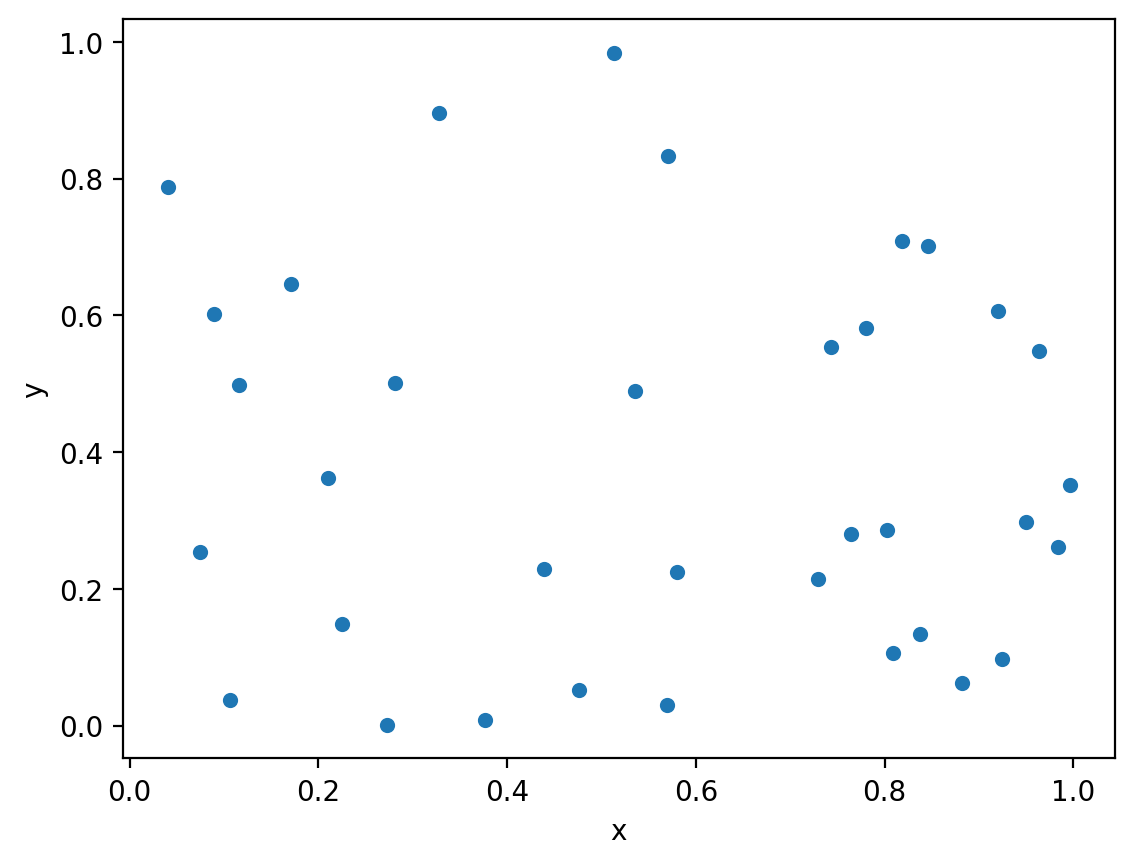

In [30]:
X2.data.plot.scatter("x", "y")

In [31]:
# Asynchronous, Vectorized
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True
X2.evaluator.vectorized = True

# This takes fewer steps to achieve a similar numver of evaluations
for _ in range(3):
    X2.step()

len(X2.data)

30